In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore") # no warnings on the console

In [2]:
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

ALGORITHMS = ["cv", "wilcoxon", "sh", "lccv-flex"]
ALGORITHM_NAMES = {"cv": "CV", "lccv-flex": "LCCV", "wilcoxon": "Wilcoxon", "sh": "SH"}

# Reading in Results and Checking Completeness

In [3]:
dfResults = pd.read_csv("../results/results_randomsearch.csv")
dfResults

,experiment_id,openmlid,train_size,algorithm,timeout,numpipelines,prob_dp,prob_fp,seed,cpus,...,time_created,host,executor,time_started,chosenmodel,errorrate,validationscores,runtime,exception,time_end
0,1,3,0.8,cv,1800,256,0.5,0.5,0,4,...,2022-05-27 05:34:47,node01-024,oculus-11185764-10,2022-05-27 05:39:10,"Pipeline(steps=[('data-pre-processor', ...",0.003037,"[0.0016,0.0016,0.0047,0.0031,0.0,0.0031,0.0016...",16838.0,NaN,2022-05-27 10:23:22
1,2,3,0.8,cv,1800,256,0.5,0.5,1,4,...,2022-05-27 05:34:47,node01-039,oculus-11185764-44,2022-05-27 05:39:11,"Pipeline(steps=[('predictor', ...",0.004682,"[0.0031,0.0,0.0047,0.0047,0.0109,0.0094,0.0031...",16802.0,NaN,2022-05-27 10:23:17
2,3,3,0.8,sh,1800,256,0.5,0.5,0,4,...,2022-05-27 05:34:47,node02-020,oculus-11185764-101,2022-05-27 05:39:13,"Pipeline(steps=[('data-pre-processor', Quantil...",0.004167,"[0.0031,0.0031,0.0031,0.0016,0.0,0.0109,0.0078...",6471.0,NaN,2022-05-27 07:30:19
3,4,3,0.9,cv,1800,256,0.5,0.5,0,4,...,2022-05-27 05:34:47,node04-042,oculus-11185764-326,2022-05-27 05:39:13,"Pipeline(steps=[('predictor', ...",0.002704,"[0.0,0.0,0.0,0.0031,0.0031,0.0,0.0,0.0062,0.0,...",30327.0,NaN,2022-05-27 14:08:07
4,5,6,0.8,cv,1800,256,0.5,0.5,0,4,...,2022-05-27 05:34:47,node02-009,oculus-11185764-81,2022-05-27 05:39:12,"Pipeline(steps=[('predictor', ...",0.029040,"[0.0322,0.023,0.0285,0.028,0.0298,0.0275,0.030...",131772.0,NaN,2022-05-28 20:09:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8881,1816,42734,0.9,wilcoxon,1800,256,0.5,0.5,5,4,...,2022-06-06 22:51:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8882,1817,42734,0.9,wilcoxon,1800,256,0.5,0.5,6,4,...,2022-06-06 22:51:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8883,1818,42734,0.9,wilcoxon,1800,256,0.5,0.5,7,4,...,2022-06-06 22:51:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8884,1819,42734,0.9,wilcoxon,1800,256,0.5,0.5,8,4,...,2022-06-06 22:51:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Results on 77 datasets.


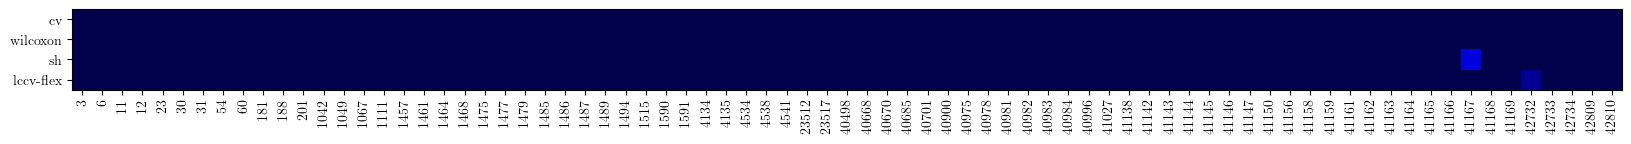

In [4]:
def plot_result_availability(dfResults):
    datasets = sorted(list(pd.unique(dfResults["openmlid"])))
    Z = np.zeros((len(ALGORITHMS), len(datasets)))
    for i, algorithm in enumerate(ALGORITHMS):
        for j, openmlid in enumerate(datasets):
            dfProjected = dfResults[(dfResults["algorithm"] == algorithm) & (dfResults["openmlid"] == openmlid)]
            dfProjected = dfProjected[dfProjected["exception"].isna()]
            Z[i,j] = len(dfProjected)
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.imshow(-Z, cmap="seismic", vmax=0, vmin=-10)
    ax.set_xticks(range(len(datasets)))
    ax.set_xticklabels(datasets, rotation=90)
    ax.set_yticks(range(len(ALGORITHMS)))
    ax.set_yticklabels(ALGORITHMS)
    plt.show()
    
print(f"Results on {len(pd.unique(dfResults['openmlid']))} datasets.")
plot_result_availability(dfResults)

In [5]:
dfResults80 = dfResults[(dfResults["train_size"] == 0.8) & (dfResults["exception"].isna())]
dfResults90 = dfResults[(dfResults["train_size"] == 0.9) & (dfResults["exception"].isna())]

# Find out "Expensive" Datasets

In [6]:
expensive_datasets = []
for openmlid, dfDataset in dfResults80.groupby("openmlid"):
    if np.mean(dfDataset[dfDataset["algorithm"] == "lccv-flex"]["runtime"]) > 3600 * 6:
        expensive_datasets.append(openmlid)
print(f"There are {len(expensive_datasets)} expensive datastes: {expensive_datasets}")

There are 37 expensive datastes: [6, 201, 1111, 1457, 1461, 1475, 1486, 1590, 1591, 4134, 4135, 4538, 4541, 23512, 23517, 40668, 40978, 40996, 41138, 41142, 41145, 41147, 41150, 41159, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 42733, 42734, 42809, 42810]


# Comparison Plots in Main Paper

In [7]:
datasets_dense = [1485, 1515, 1475, 1468, 1489, 23512, 23517, 40981, 40982, 40983, 40984, 40701, 40685, 40900,  1111, 40498, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 41142, 41143, 41144, 41145, 41146, 41150, 41156, 41157, 41158,  41159, 41138, 54, 181, 188, 1461, 1494, 1464, 12, 23, 3, 1487, 40668, 1067, 1049, 40975, 31]
#1457
datasets_sparse = [1590, 1486, 4534, 4541, 4538, 4134, 4135, 40978, 40996, 41027, 40670, 42732, 42733, 42734, 41147]
datasets = datasets_dense + datasets_sparse

In [8]:
def create_summary_boxplots(df, train_size, axs = None):
    
    if axs is None:
        fig, axs = plt.subplots(1, 4, figsize=(8, 3), gridspec_kw={'width_ratios': [1.2, 1, 1, 1]})
    else:
        fig = None

    # get prefixes
    prefix1 = "5" if train_size == 0.8 else "10"
    prefix2 = "80" if train_size == 0.8 else "90"
    algorithm_names = {a: (prefix1 if a in ["cv", "wilcoxon"] else prefix2) + "-" + ALGORITHM_NAMES[a] for a in ALGORITHMS}
    
    # comute mean runtimes per dataset
    df_mean_runtimes = df.groupby(["algorithm", "openmlid"]).mean(numeric_only=True)["runtime"].dropna().reset_index()
    df_mean_performances = df.groupby(["algorithm", "openmlid"]).mean(numeric_only=True)["errorrate"].dropna().reset_index()
    
    # absolute runtimes
    datasets = pd.unique(df["openmlid"])
    ax = axs[0]
    ax.boxplot([df_mean_runtimes[df_mean_runtimes["algorithm"] == a]["runtime"].values / 3600 for a in ALGORITHMS])
    ax.set_title("Absolute\nRuntimes (h)")
    ax.set_xticks(range(1, 5))
    ax.set_xticklabels([algorithm_names[a] for a in ALGORITHMS], rotation=80)
    
    # runtime changes
    reductions_abs = []
    reductions_rel = []
    for openmlid, df_dataset in df_mean_runtimes.groupby("openmlid"):
        runtimes_on_this_dataset = df_dataset.set_index("algorithm").to_dict()["runtime"]
        missing_algorithms = [a for a in ALGORITHMS if a not in runtimes_on_this_dataset.keys()]
        if not missing_algorithms:
            reductions_abs.append([runtimes_on_this_dataset["cv"] - runtimes_on_this_dataset[a] for a in ALGORITHMS if a != "cv"])
            reductions_rel.append([runtimes_on_this_dataset[a] / runtimes_on_this_dataset["cv"] for a in ALGORITHMS if a != "cv"])
        else:
            print(f"Incomplete results on dataset {openmlid}. No results for algorithms: {missing_algorithms}")
    
    for i, (name, reductions) in enumerate([("Absolute\nReduction (m)", reductions_abs), ("Relative Runtimes", reductions_rel)], 1):
        reductions = np.array(reductions)
        if i == 1:
            reductions /= 60
            print(f"Median of absolute reduction is {np.median(reductions[:,0])} for 80LCCV and {np.median(reductions[:,1])} for 90LCCV")
            print(f"Mean of absolute reduction is {np.mean(reductions[:,0])} for 80LCCV and {np.mean(reductions[:,1])} for 90LCCV")
        else:
            print(f"Median of relative reduction is {np.median(reductions[:,0])} for 80LCCV and {np.median(reductions[:,1])} for 90LCCV")
            print(f"Mean of relative reduction is {np.mean(reductions[:,0])} for 80LCCV and {np.mean(reductions[:,1])} for 90LCCV")
        axs[i].violinplot(reductions, showmedians=True)
        axs[i].set_title(name)
    axs[1].axhline(0, linewidth=1, color="black")
    
    # info on percentage of observations with runtime reductions of at least 50%
    print(np.count_nonzero(np.array(reductions_rel) <= 0.5, axis=0) / len(reductions_rel[1]))
    print(np.mean(np.array(reductions_abs), axis=0)/3600)
    
    # performance diffs
    performance_diffs = []
    for openmlid, df_dataset in df_mean_performances.groupby("openmlid"):
        performances_on_this_dataset = df_dataset.set_index("algorithm").to_dict()["errorrate"]
        missing_algorithms = [a for a in ALGORITHMS if a not in performances_on_this_dataset.keys()]
        if not missing_algorithms:
            performance_diffs.append([performances_on_this_dataset[a] - performances_on_this_dataset["cv"] for a in ALGORITHMS if a != "cv"])
        #print(openmlid, performance_diffs[-1], performances_on_this_dataset)
    performance_diffs = np.array(performance_diffs)
    
    # deviations in performance
    axs[3].boxplot(performance_diffs)
    axs[3].set_title("Performance\nGaps")
    for threshold in [0.005, 0.01, 0.015]:
        for i, diffs in enumerate(performance_diffs.T):
            print(f"{np.round(100 * np.count_nonzero(diffs <= threshold) / len(diffs), 2)}% of the observed error rates of lccv deviate by at most {threshold} from the {'5CV' if i == 0 else '10CV'} baseline.")
    
    # set x labels for comparative plots
    for i in range(1, 4):
        axs[i].set_xticks(range(1, 4))
        axs[i].set_xticklabels([algorithm_names[a] for a in ALGORITHMS if a != "cv"], rotation=80)
    
    if fig is not None:
        fig.tight_layout()
        fig.savefig("plots/results-randomsearch-boxplots.pdf")
        plt.show()
    
    for a in ALGORITHMS:
        print(f"Avg. Total Runtime of {a}: {np.round(df_mean_runtimes[df_mean_runtimes['algorithm'] == a]['runtime'].mean())}")

# Figure 2 in Main Paper

Incomplete results on dataset 42732. No results for algorithms: ['lccv-flex']
Incomplete results on dataset 42734. No results for algorithms: ['cv', 'wilcoxon']
Median of absolute reduction is -0.38188596491227145 for 80LCCV and 631.3685185185185 for 90LCCV
Mean of absolute reduction is -5.777128777189294 for 80LCCV and 1070.181248588549 for 90LCCV
Median of relative reduction is 1.000668484017155 for 80LCCV and 0.21468244817372228 for 90LCCV
Mean of relative reduction is 1.0036395424740496 for 80LCCV and 0.2712103085345924 for 90LCCV
[ 0.         22.66666667 14.        ]
[-0.09628548 17.83635414 13.95614321]
98.67% of the observed error rates of lccv deviate by at most 0.005 from the 5CV baseline.
73.33% of the observed error rates of lccv deviate by at most 0.005 from the 10CV baseline.
84.0% of the observed error rates of lccv deviate by at most 0.005 from the 10CV baseline.
100.0% of the observed error rates of lccv deviate by at most 0.01 from the 5CV baseline.
89.33% of the obser

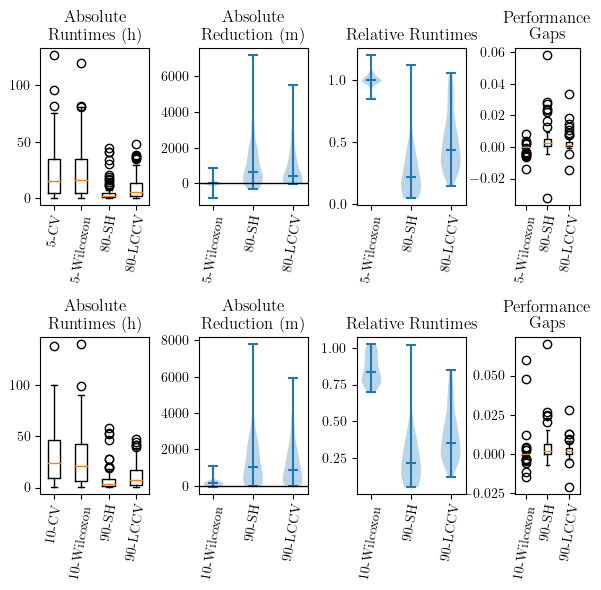

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1, 1, .6]})

create_summary_boxplots(dfResults80, train_size=0.8, axs=axs[0])
create_summary_boxplots(dfResults90, train_size=0.9, axs=axs[1])

fig.tight_layout()
fig.subplots_adjust(wspace = .5)
fig.savefig("plots/results-randomsearch-boxplots.pdf")
plt.show()

# Figures 2 and 3 in Appendix

Incomplete results on dataset 42732. No results for algorithms: ['lccv-flex']
Incomplete results on dataset 42734. No results for algorithms: ['cv', 'wilcoxon']
Median of absolute reduction is -0.38188596491227145 for 80LCCV and 631.3685185185185 for 90LCCV
Mean of absolute reduction is -5.777128777189294 for 80LCCV and 1070.181248588549 for 90LCCV
Median of relative reduction is 1.000668484017155 for 80LCCV and 0.21468244817372228 for 90LCCV
Mean of relative reduction is 1.0036395424740496 for 80LCCV and 0.2712103085345924 for 90LCCV
[ 0.         22.66666667 14.        ]
[-0.09628548 17.83635414 13.95614321]
98.67% of the observed error rates of lccv deviate by at most 0.005 from the 5CV baseline.
73.33% of the observed error rates of lccv deviate by at most 0.005 from the 10CV baseline.
84.0% of the observed error rates of lccv deviate by at most 0.005 from the 10CV baseline.
100.0% of the observed error rates of lccv deviate by at most 0.01 from the 5CV baseline.
89.33% of the obser

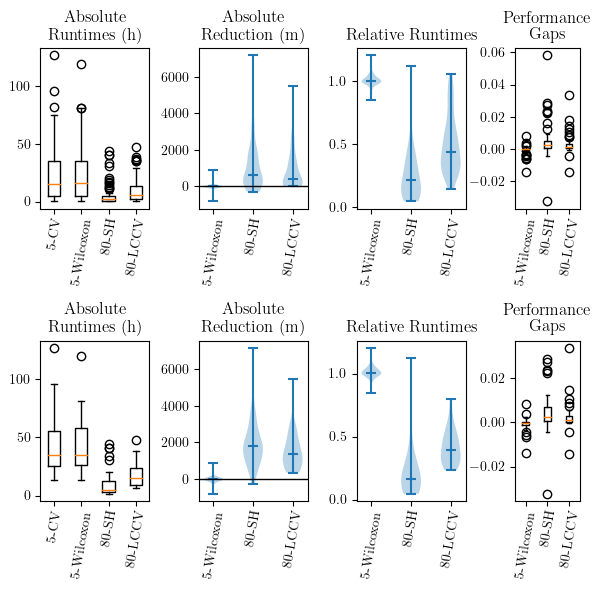

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1, 1, .6]})

create_summary_boxplots(dfResults80, train_size=0.8, axs=axs[0])
create_summary_boxplots(dfResults80[dfResults80["openmlid"].isin(expensive_datasets)], train_size=0.8, axs=axs[1])

fig.tight_layout()
fig.subplots_adjust(wspace = .5)
fig.savefig("plots/results-randomsearch-boxplots-detailed-80.pdf")
plt.show()

Incomplete results on dataset 41167. No results for algorithms: ['sh']
Incomplete results on dataset 42732. No results for algorithms: ['lccv-flex']
Incomplete results on dataset 42734. No results for algorithms: ['cv', 'wilcoxon']
Median of absolute reduction is 129.28657407407403 for 80LCCV and 1025.7531845238095 for 90LCCV
Mean of absolute reduction is 150.02758631495863 for 80LCCV and 1352.4100839687817 for 90LCCV
Median of relative reduction is 0.8387570548329297 for 80LCCV and 0.21326290850347052 for 90LCCV
Mean of relative reduction is 0.8527950363069201 for 80LCCV and 0.2758570998127382 for 90LCCV
[ 0.         22.33333333 18.66666667]
[ 2.50045977 22.54016807 19.72875069]
95.95% of the observed error rates of lccv deviate by at most 0.005 from the 5CV baseline.
71.62% of the observed error rates of lccv deviate by at most 0.005 from the 10CV baseline.
83.78% of the observed error rates of lccv deviate by at most 0.005 from the 10CV baseline.
95.95% of the observed error rates o

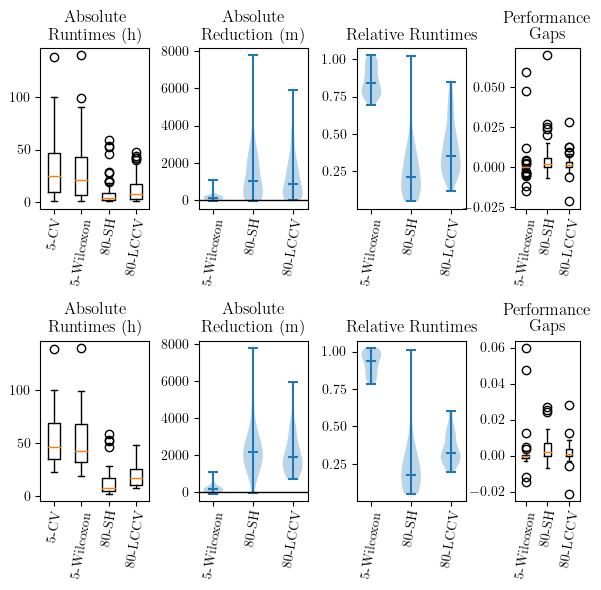

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1, 1, .6]})

create_summary_boxplots(dfResults90, train_size=0.8, axs=axs[0])
create_summary_boxplots(dfResults90[dfResults90["openmlid"].isin(expensive_datasets)], train_size=0.8, axs=axs[1])

fig.tight_layout()
fig.subplots_adjust(wspace = .5)
fig.savefig("plots/results-randomsearch-boxplots-detailed-90.pdf")
plt.show()

# Figures 4 and 5 in Appendix

In [12]:
def create_summary_scatterplot(train_size):
    
    if train_size == 0.8:
        df = dfResults80
    elif train_size == 0.9:
        df = dfResults90
    else:
        raise ValueError(f"train_size must be 0.8 or 0.9")
        
    fig, ax = plt.subplots(figsize=(15, 15))
    i = 0

    lccv_name = ("80-" if train_size == 0.8 else "90-") + ALGORITHM_NAMES["lccv-flex"]
    base_name = ("5-" if train_size == 0.8 else "10-") + ALGORITHM_NAMES["cv"]

    for openmlid, df_dataset in df.groupby("openmlid"):
        results_on_dataset = df_dataset[["algorithm", "seed", "runtime", "errorrate"]].dropna()
        results_on_dataset = results_on_dataset[results_on_dataset["algorithm"].isin(["cv", "lccv-flex"])]
        
        lccv_scores = results_on_dataset[results_on_dataset["algorithm"] == "lccv-flex"]["errorrate"].values
        lccv_times = results_on_dataset[results_on_dataset["algorithm"] == "lccv-flex"]["runtime"].values / 3600
        mccv_scores = results_on_dataset[results_on_dataset["algorithm"] == "cv"]["errorrate"].values
        mccv_times = results_on_dataset[results_on_dataset["algorithm"] == "cv"]["runtime"].values / 3600
        
        lccv_mean_score = np.nanmedian(lccv_scores) if len(lccv_scores) > 0 else np.nan
        lccv_mean_time = np.nanmedian(lccv_times) if len(lccv_times) > 0 else np.nan
        mccv_mean_score = np.nanmedian(mccv_scores) if len(mccv_scores) > 0 else np.nan
        mccv_mean_time = np.nanmedian(mccv_times) if len(mccv_times) > 0 else np.nan
        
        lccv_has_result = not np.isnan(lccv_mean_time)
        mccv_has_result = not np.isnan(mccv_mean_time)
        
        if lccv_has_result:
            ax.scatter(lccv_mean_time, lccv_mean_score, color="C0", label=lccv_name if i == 0 else None)
            ax.plot([lccv_mean_time, lccv_mean_time], [np.percentile(lccv_scores, 20), np.percentile(lccv_scores, 80)], color="C0", linewidth=1, alpha=0.5)
            
            if mccv_has_result:
                ax.scatter(mccv_mean_time, mccv_mean_score, color="C1", label=base_name if i == 0 else None)
                ax.plot([mccv_mean_time, mccv_mean_time], [np.percentile(mccv_mean_score, 20), np.percentile(mccv_mean_score, 80)], color="C1", linewidth=1, alpha=0.5) # vertical line for range
                ax.plot([lccv_mean_time, mccv_mean_time], [lccv_mean_score, mccv_mean_score], color="green" if lccv_mean_time <= mccv_mean_time else "red", linestyle="--", linewidth=1) # connecting line
                ax.text((lccv_mean_time + mccv_mean_time) / 2.2, (lccv_mean_score + mccv_mean_score) / 2, int(openmlid))
                avg_time_saving = int((mccv_mean_time - lccv_mean_time) * 60)
                avg_reduction = np.round((1 - lccv_mean_time / mccv_mean_time) * 100)
                ax.text((lccv_mean_time + mccv_mean_time) / 2.5, (lccv_mean_score + mccv_mean_score) / 2 - 0.01, f"{avg_time_saving}m ({avg_reduction}\%)")
            else:
                ax.text(lccv_mean_time, lccv_mean_score, int(openmlid))
        
        i += 1

    ax.set_xlabel("Runtime (s)")
    ax.set_ylabel("Error Rate")
    for y in np.linspace(0, 0.7, 71):
        ax.axhline(y, alpha=0.05, color="black")
    
    for t in [1800, 3600, 86400]:
        ax.axvline(t / 3600, linestyle="--", color="black", linewidth=1)
    ax.set_ylim([0, 0.7])
    ax.set_xlim([10**-1, 5 * 10**2])
    ax.set_xscale("log")
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"plots/results-randomsearch-scatter-{int(100 * train_size)}.pdf")
    plt.show()

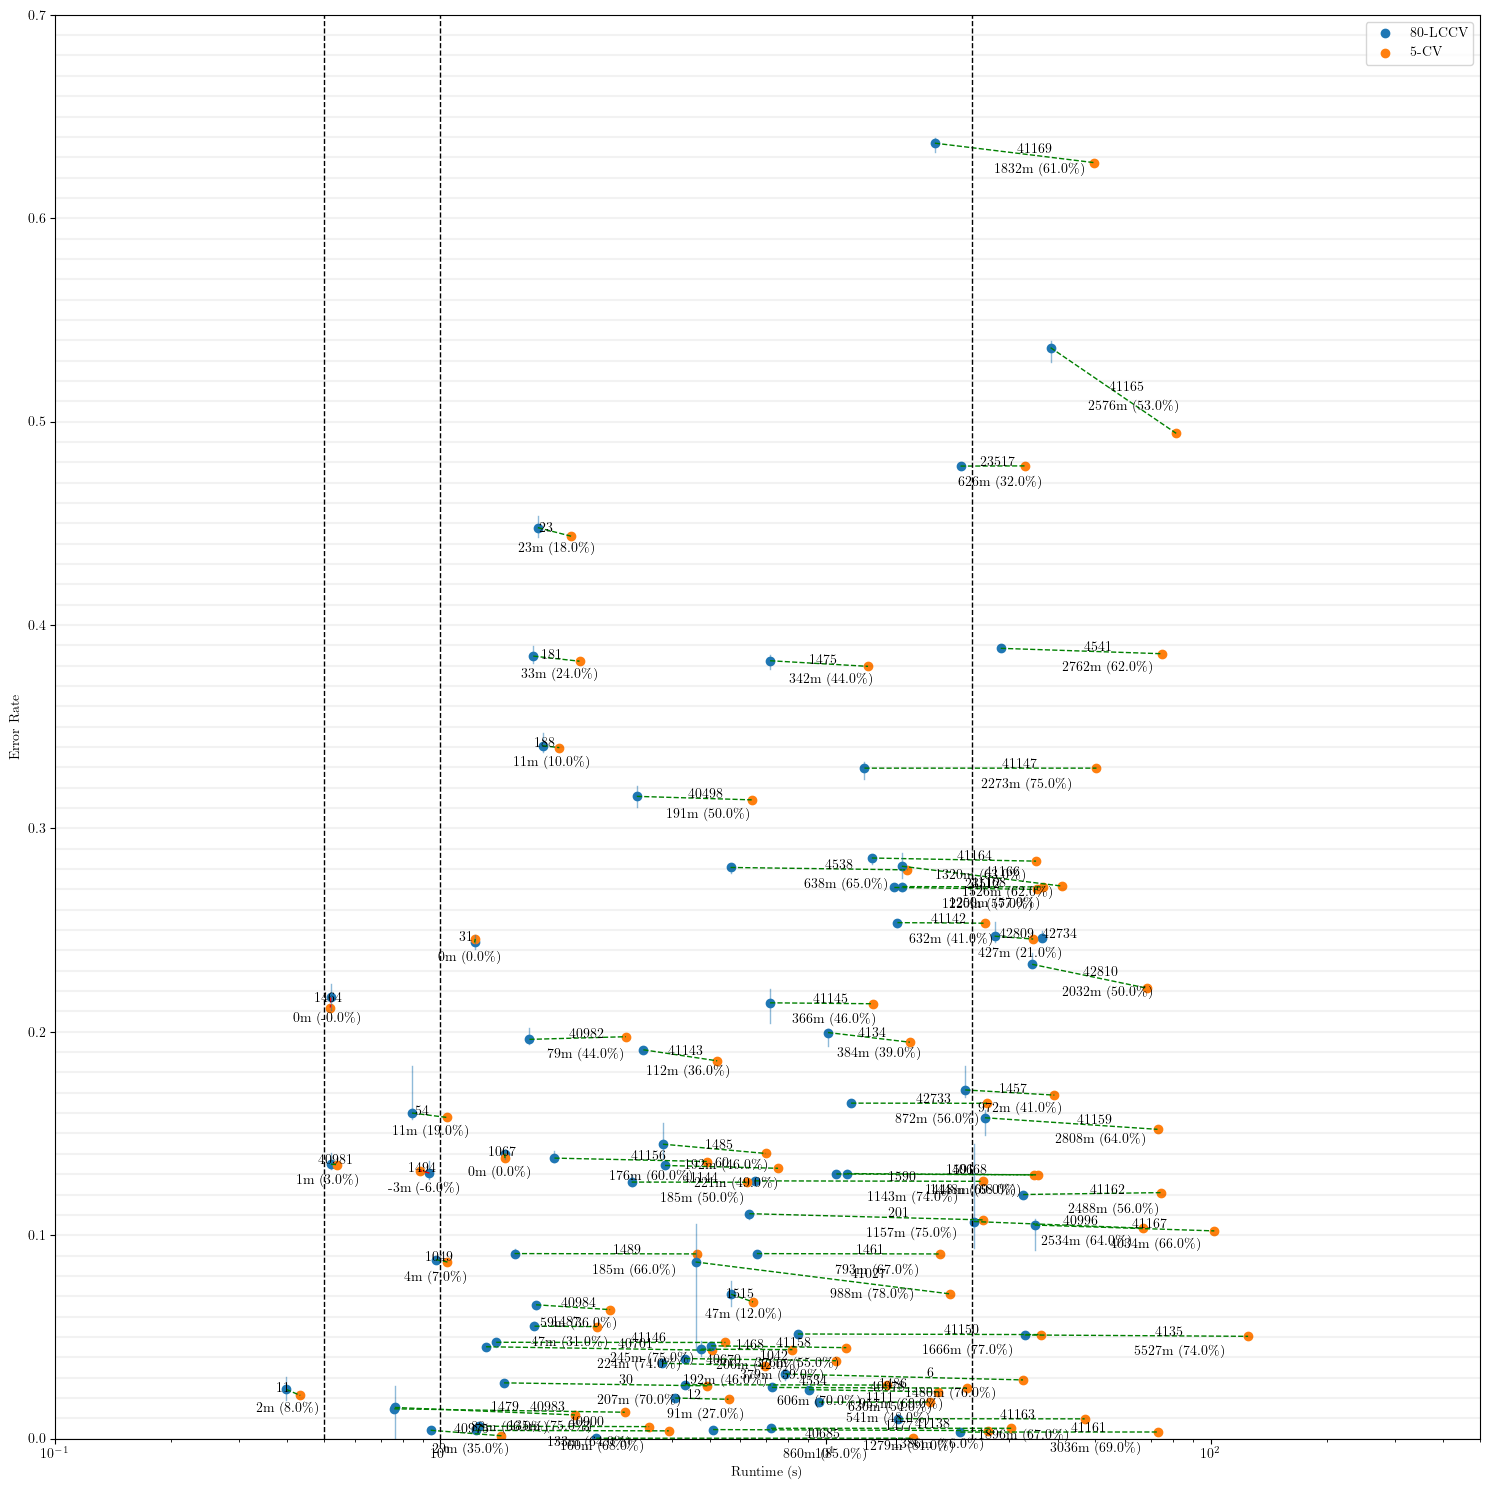

In [13]:
create_summary_scatterplot(train_size=0.8)

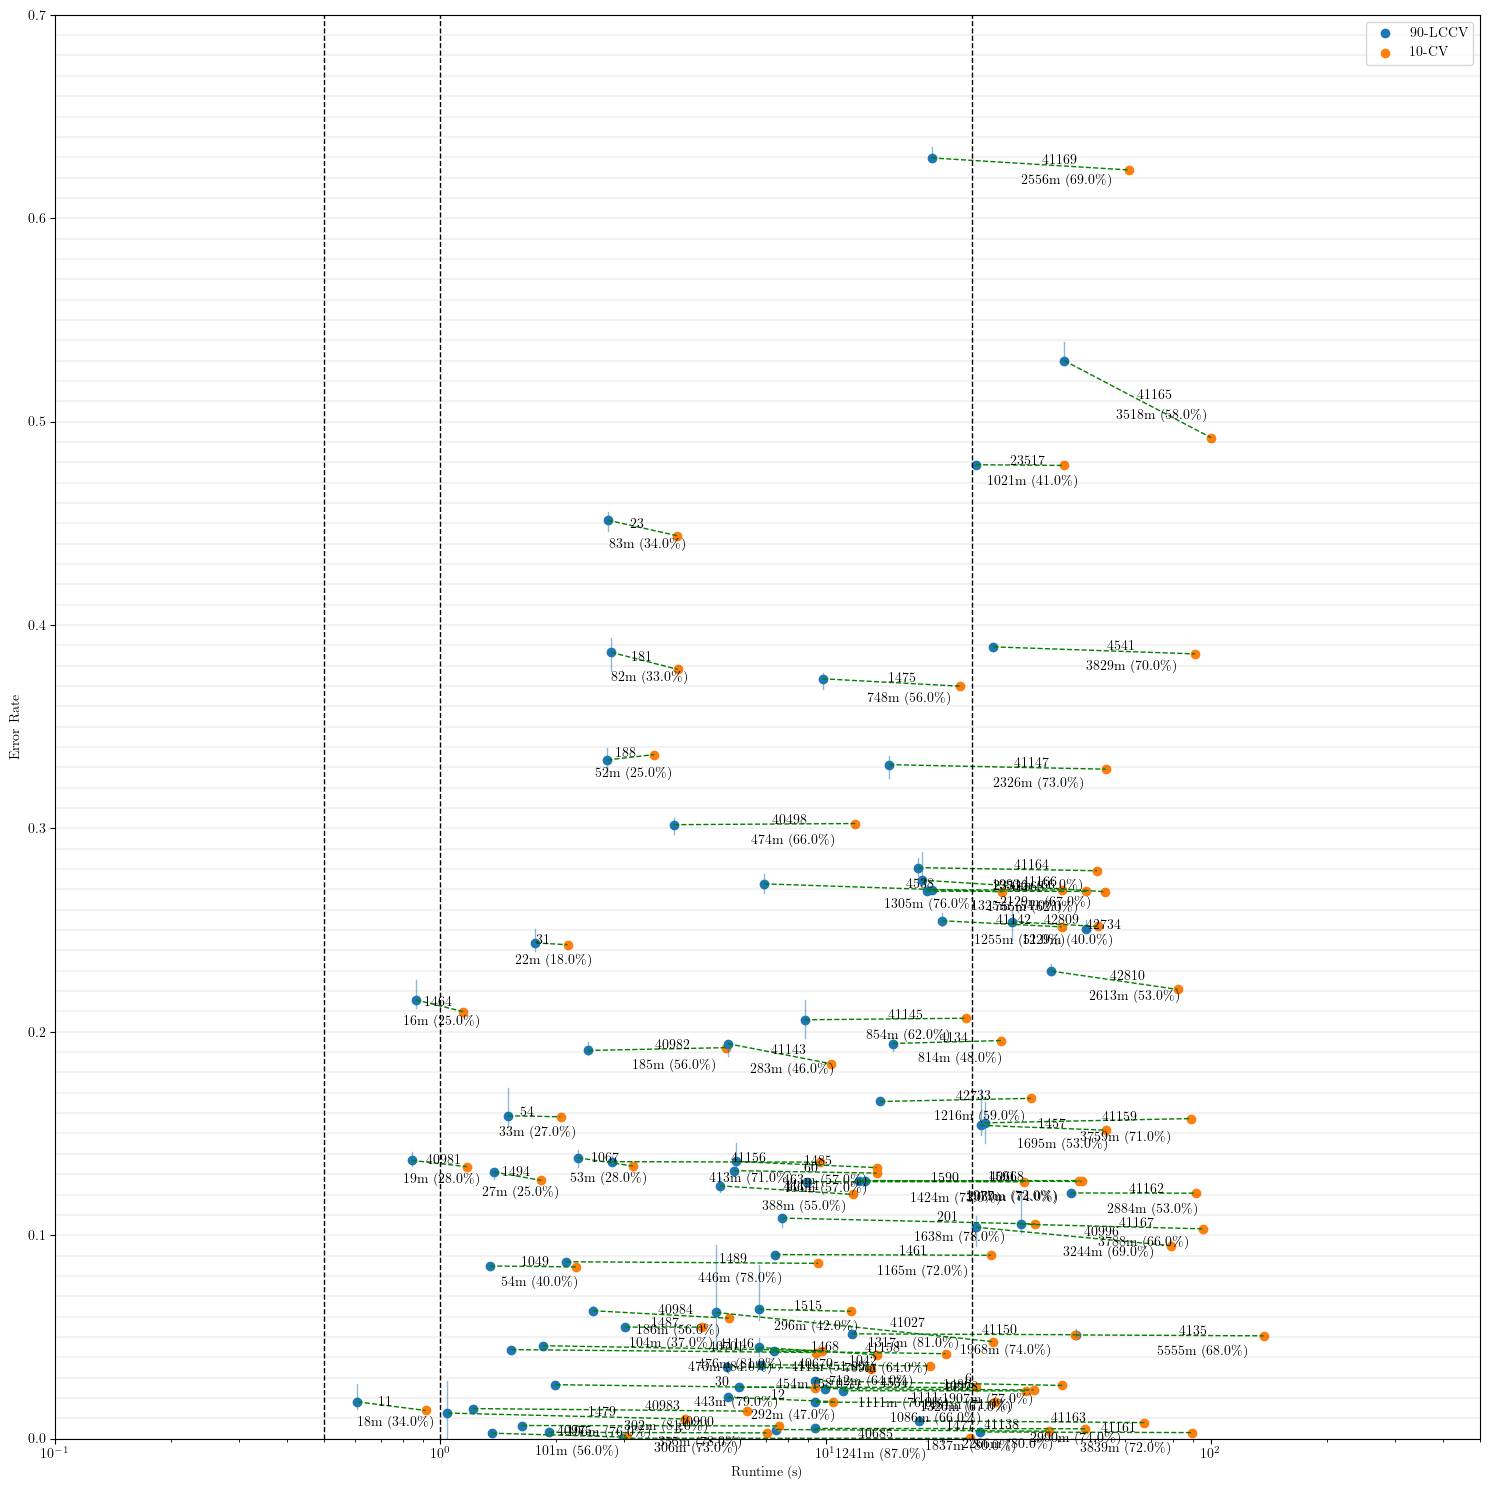

In [14]:
create_summary_scatterplot(train_size=0.9)

# Table 2 and Table 3 in Appendix

In [15]:
def get_latex_table(df):
    df = df[df["errorrate"].notna()]
    rows = []
    algorithms = ["cv", "sh", "lccv-flex", "wilcoxon"]
    for openmlid in tqdm(sorted(pd.unique(df["openmlid"]))):
        df_ds = df[df["openmlid"] == openmlid]
        row = [openmlid]
        for algo in algorithms:
            sub_df = df_ds[df_ds["algorithm"] == algo]
            
            if len(sub_df) > 0:
                performance = str(np.round(np.mean(sub_df["errorrate"]), 2)) + "$\pm$" + '{:04.2f}'.format(np.std(sub_df["errorrate"]), 2)
                runtime = str(int(np.round(np.mean(sub_df["runtime"])))) + "$\pm$" + str(int(np.round(np.std(sub_df["runtime"]))))
            else:
                performance, runtime = np.nan, np.nan

            row.extend([performance, runtime])
        rows.append(row)
    columns = ["openmlid"]
    for a in algorithms:
        columns.extend([f"{a} Perf", f"{a} Runtime"])
    return pd.DataFrame(rows, columns=columns).to_latex(index=False, escape=False).replace('{rllllllll}', '{r|rr|rr|rr|rr}')

In [16]:
print(get_latex_table(dfResults80))

  0%|          | 0/77 [00:00<?, ?it/s]

\begin{tabular}{r|rr|rr|rr|rr}
\toprule
openmlid & cv Perf & cv Runtime & sh Perf & sh Runtime & lccv-flex Perf & lccv-flex Runtime & wilcoxon Perf & wilcoxon Runtime \\
\midrule
3 & 0.0$\pm$0.00 & 14239$\pm$2324 & 0.01$\pm$0.01 & 4449$\pm$3361 & 0.01$\pm$0.01 & 4957$\pm$1852 & 0.0$\pm$0.00 & 13978$\pm$2476 \\
6 & 0.04$\pm$0.03 & 116386$\pm$11074 & 0.03$\pm$0.00 & 13786$\pm$3343 & 0.04$\pm$0.02 & 28168$\pm$5353 & 0.03$\pm$0.00 & 122640$\pm$9053 \\
11 & 0.02$\pm$0.01 & 1710$\pm$700 & 0.03$\pm$0.01 & 1881$\pm$2175 & 0.04$\pm$0.07 & 1608$\pm$618 & 0.02$\pm$0.01 & 1691$\pm$685 \\
12 & 0.02$\pm$0.00 & 21695$\pm$3486 & 0.02$\pm$0.00 & 8277$\pm$4247 & 0.02$\pm$0.00 & 14688$\pm$2995 & 0.02$\pm$0.00 & 21321$\pm$3280 \\
23 & 0.45$\pm$0.01 & 7808$\pm$1774 & 0.45$\pm$0.01 & 3096$\pm$2055 & 0.45$\pm$0.01 & 6569$\pm$1453 & 0.44$\pm$0.01 & 7831$\pm$2017 \\
30 & 0.03$\pm$0.00 & 18522$\pm$3932 & 0.03$\pm$0.00 & 2039$\pm$731 & 0.03$\pm$0.00 & 5756$\pm$1874 & 0.03$\pm$0.00 & 18653$\pm$3961 \\
31 & 0.25$\

In [17]:
print(get_latex_table(dfResults90))

  0%|          | 0/77 [00:00<?, ?it/s]

\begin{tabular}{r|rr|rr|rr|rr}
\toprule
openmlid & cv Perf & cv Runtime & sh Perf & sh Runtime & lccv-flex Perf & lccv-flex Runtime & wilcoxon Perf & wilcoxon Runtime \\
\midrule
3 & 0.0$\pm$0.00 & 26083$\pm$3506 & 0.0$\pm$0.00 & 7471$\pm$4260 & 0.0$\pm$0.00 & 7268$\pm$2586 & 0.0$\pm$0.00 & 19157$\pm$3092 \\
6 & 0.03$\pm$0.00 & 150342$\pm$11642 & 0.03$\pm$0.00 & 25064$\pm$5476 & 0.03$\pm$0.00 & 34948$\pm$5698 & 0.03$\pm$0.00 & 137553$\pm$8757 \\
11 & 0.02$\pm$0.01 & 3526$\pm$1148 & 0.02$\pm$0.01 & 3599$\pm$3166 & 0.02$\pm$0.01 & 2404$\pm$1041 & 0.02$\pm$0.01 & 2593$\pm$929 \\
12 & 0.02$\pm$0.00 & 38677$\pm$4319 & 0.02$\pm$0.00 & 12667$\pm$4796 & 0.02$\pm$0.00 & 19699$\pm$3515 & 0.02$\pm$0.00 & 28955$\pm$3536 \\
23 & 0.45$\pm$0.01 & 15132$\pm$2942 & 0.45$\pm$0.01 & 5434$\pm$2243 & 0.45$\pm$0.01 & 10124$\pm$2334 & 0.44$\pm$0.01 & 12032$\pm$2900 \\
30 & 0.03$\pm$0.00 & 35280$\pm$5466 & 0.03$\pm$0.02 & 3958$\pm$994 & 0.03$\pm$0.00 & 7988$\pm$3042 & 0.03$\pm$0.00 & 26860$\pm$4922 \\
31 & 0.